# HarvestStat Data Profiling - Benin

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32631' # Benin
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/BJ_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country':  'Benin',
    'product': ['R011','R012','R013','R014','R015','R017','R018'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint,  params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1982	 | BJ1982A1 | 6	| BJ1982A2	| 77	| nan	| 0	|
| 1999	 | BJ1999A1 | 12	| BJ1999A2	| 77	| nan	| 0	|
| 2015	 | BJ2015A1 | 12	| BJ2015A2	| 77	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Save data
df_raw_out = '../data/crop_raw_data/adm_crop_data_raw_BJ.csv'
df.to_csv(df_raw_out); print(f'{df_raw_out} is saved.')

../data/crop_raw_data/adm_crop_data_raw_BJ.csv is saved.


In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
df = df[np.isfinite(df.value)]
df_admin1=df[df['admin_2'].isna()]
df = df.dropna(subset=['admin_2'])

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority="Area Planted")
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([BJ_Admin2_1982, BJ_Admin2_1999, BJ_Admin2_2015], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 79,081
26,367/26,367 "Area Harvested" points are retained.
26,359/26,359 "Quantity Produced" points are retained.
26,355/26,355 "Yield" points are retained.
Current data points: 79,081

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1995 - 2021
32 grain types are found: African Eggplant, Bambara groundnut, Cabbage (Unspecified), Carrots, Cassava, Colocynth, Cowpea (unspecified), Cucumber, Fonio, Geocarpa groundnut, Goussi, Green pea, Groundnuts (In Shell), Jews mallow leaves, Lettuce (Unspecified), Maize (Corn), Millet (Foxtail), Okras (Fresh), Onions, Pigeon pea (Unspecified), Pineapple (unspecified), Potato (unspecified), Rice (Paddy), Sesame Seed, Sorghum, Soybean (unspecified), Sugarcane (for sugar), Sweet Potatoes, Taro/Cocoyam (Unspecified), Tomato, Watermelon, Yams
2 seasons are found: Main (11-01), Annual (12-01)
1 crop production system are

- Benin crop seasonal calendar

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/wafrica_bn_calendar.png"  width=900>

- comparison of boundaries</br>

<img src="../figures/BJ_admin_shapes.png"  width=900>

- In Benin, basd on the FEWS NET data, there were two times of changes in administrative units. We will use the 2015 administrative units

| Year  | Admin-1  | # units  | Admin-2  | # units | Admin-3  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   | :----:   | :---:   |
| 1982	 | BJ1982A1 | 6	| BJ1982A2	| 77	| nan	| 0	|
| 1999	 | BJ1999A1 | 12	| BJ1999A2	| 77	| nan	| 0	|
| 2015	 | BJ2015A1 | 12	| BJ2015A2	| 77	| nan	| 0	|


In [5]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = BJ_Admin2_2015.copy().to_crs('epsg:32621')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [6]:
# Link admin boundaries ------------------------- #
link_1982, over_1982 = FDW_PD_CreateAdminLink(BJ_Admin2_1982, BJ_Admin2_2015, 'ADMIN2', 'ADMIN2', prod, epsg)
# assert all(np.unique([v['method'] for k,v in link_1982.items()]) == 'PBR')
link_1999, over_1999 = FDW_PD_CreateAdminLink(BJ_Admin2_1999, BJ_Admin2_2015, 'ADMIN2', 'ADMIN2', prod, epsg)
# assert all(np.unique([v['method'] for k,v in link_1999.items()]) == 'PBR')
# Crop specific ratios
link_ratio_1982 = FDW_PD_RatioAdminLink(link_1982, prod, over_1982, mdx_pss)
link_ratio_1999 = FDW_PD_RatioAdminLink(link_1999, prod, over_1999, mdx_pss)
# Merge link_ratio
assert link_ratio_1982.keys() == link_ratio_1999.keys()
link_merged = [link_ratio_1982, link_ratio_1999]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=True)
# ----------------------------------------------- #

In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0


All [country, season_name] are in the external season calendar.


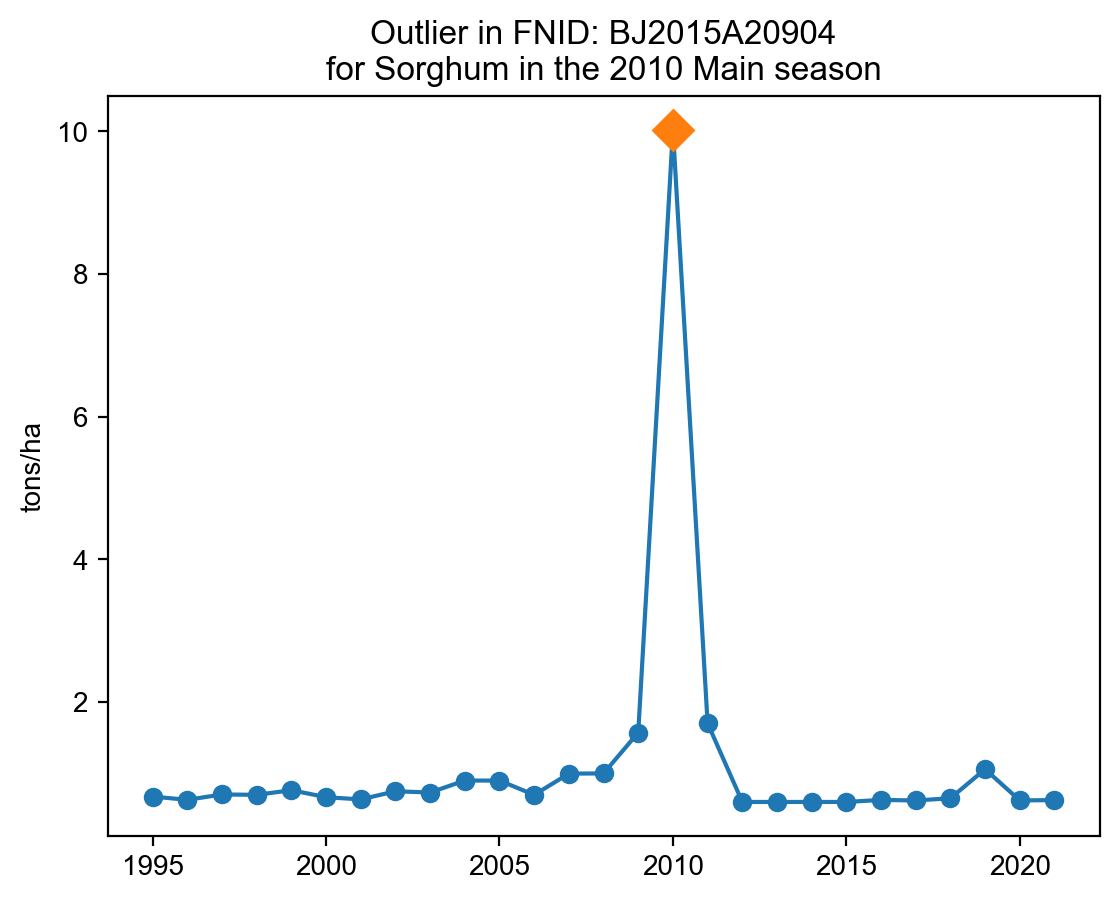

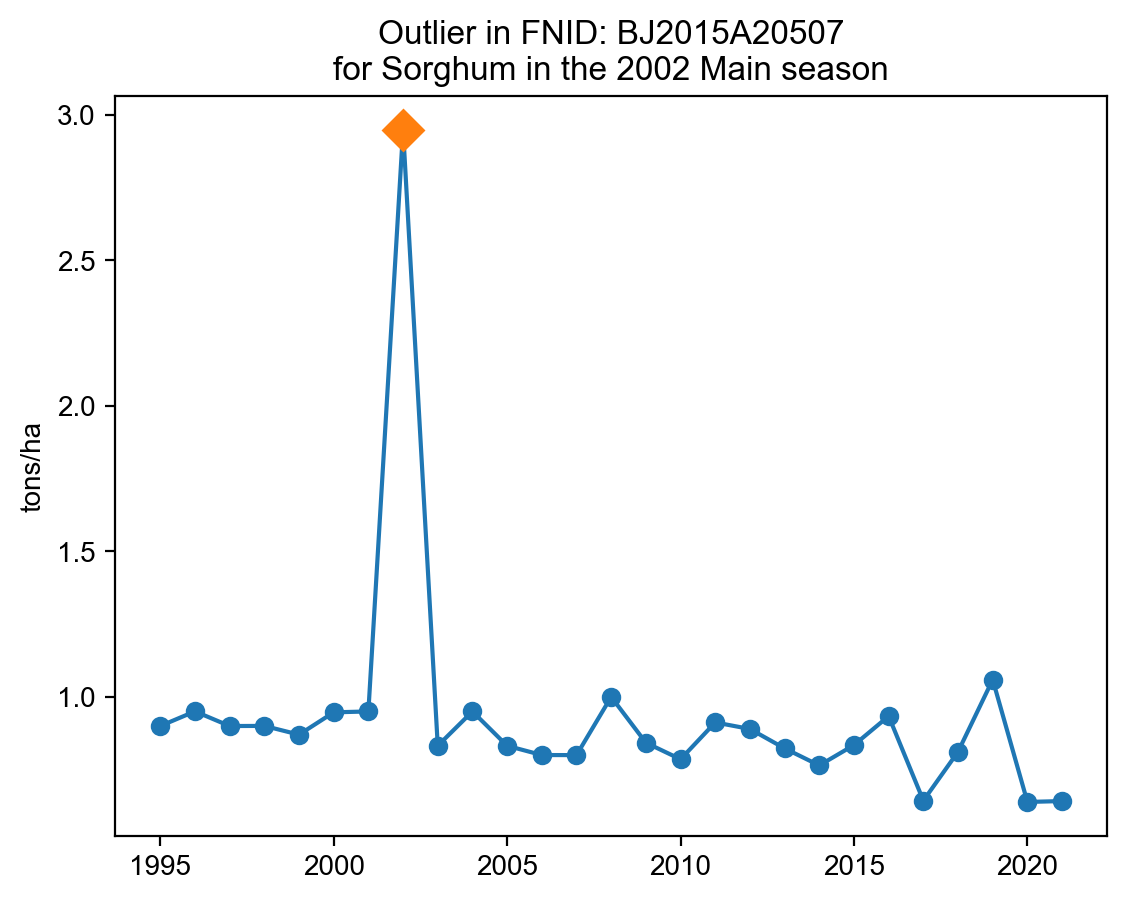

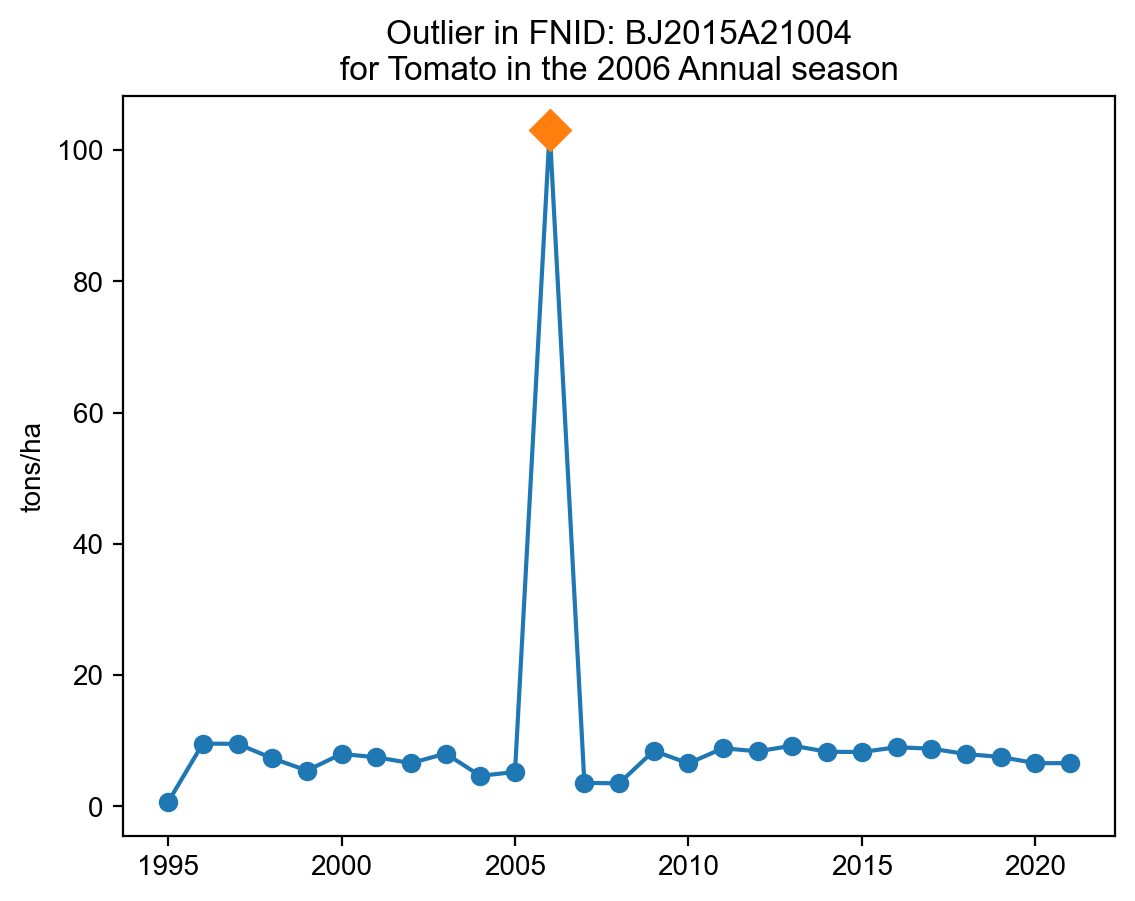

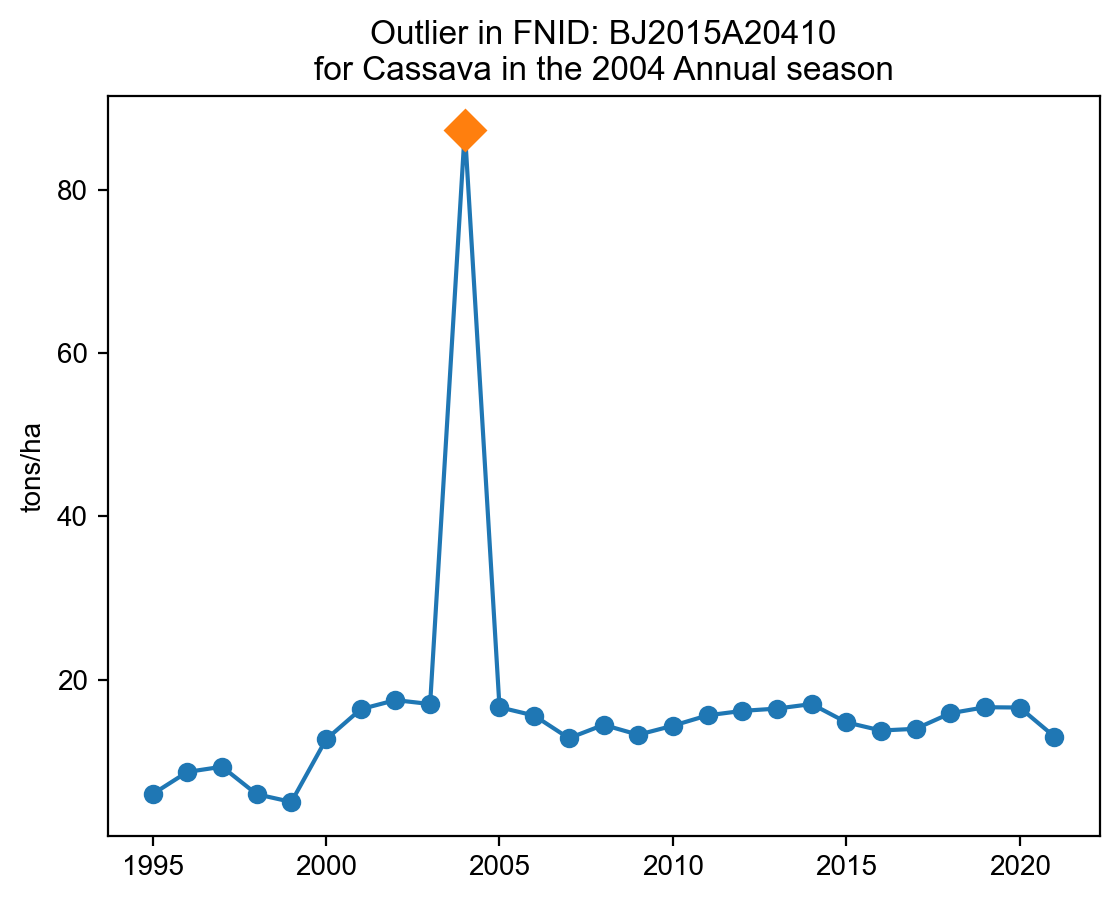

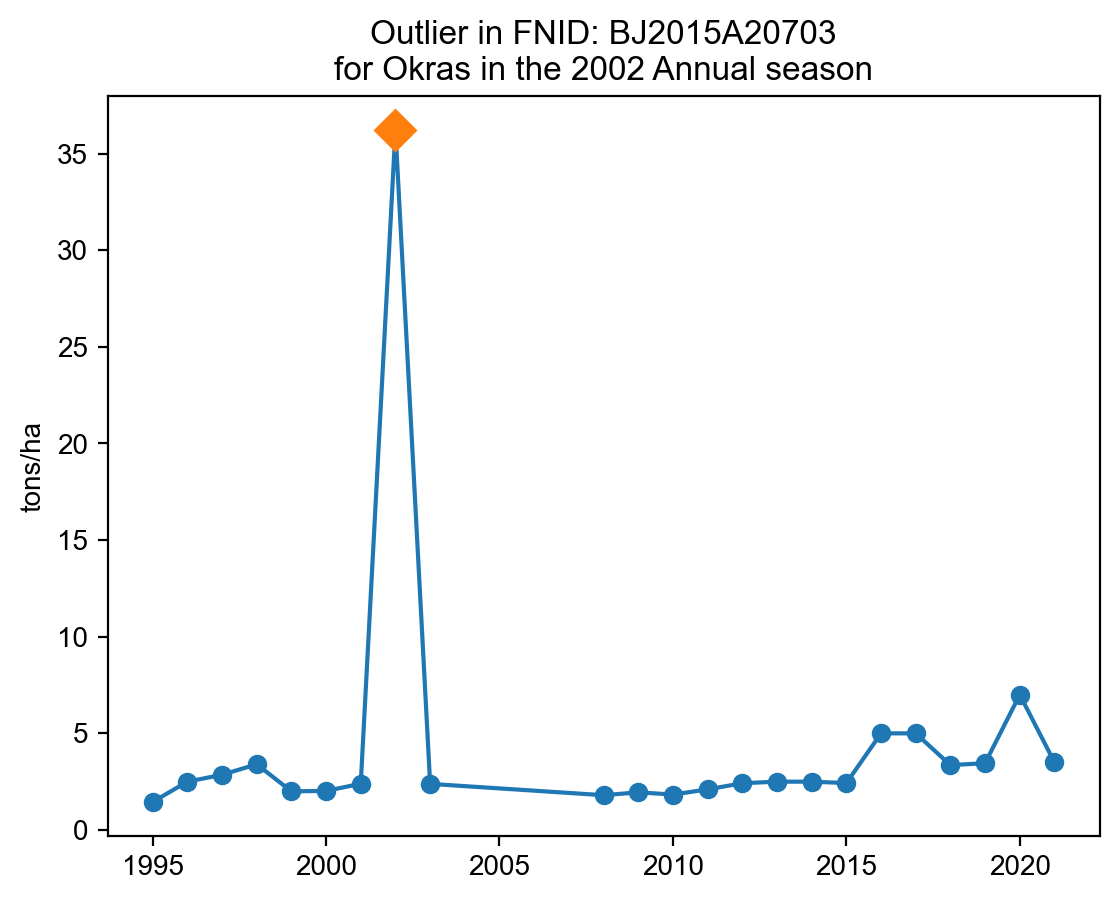

In [8]:
from matplotlib import pyplot as plt

outliers = [
            ['BJ2015A20904','Sorghum','Main',2010],
            ['BJ2015A20507','Sorghum','Main',2002],
            ['BJ2015A21004','Tomato','Annual',2006],
            ['BJ2015A20410','Cassava','Annual',2004],
            ['BJ2015A20703','Okras','Annual',2002],
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then flag the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title('Outlier in FNID: '+iou[0]+'\nfor '+iou[1]+' in the '+str(iou[3])+' '+iou[2]+' season')
    plt.ylabel('tons/ha')
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1  
    


In [9]:

# Save data
fn_out = '../data/crop/adm_crop_production_BJ.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_BJ_ratio.npz', link_ratio)

../data/crop/adm_crop_production_BJ.csv is saved.
../data/crop/adm_crop_production_BJ_ratio.npz is saved.


# Visualization of production data

/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


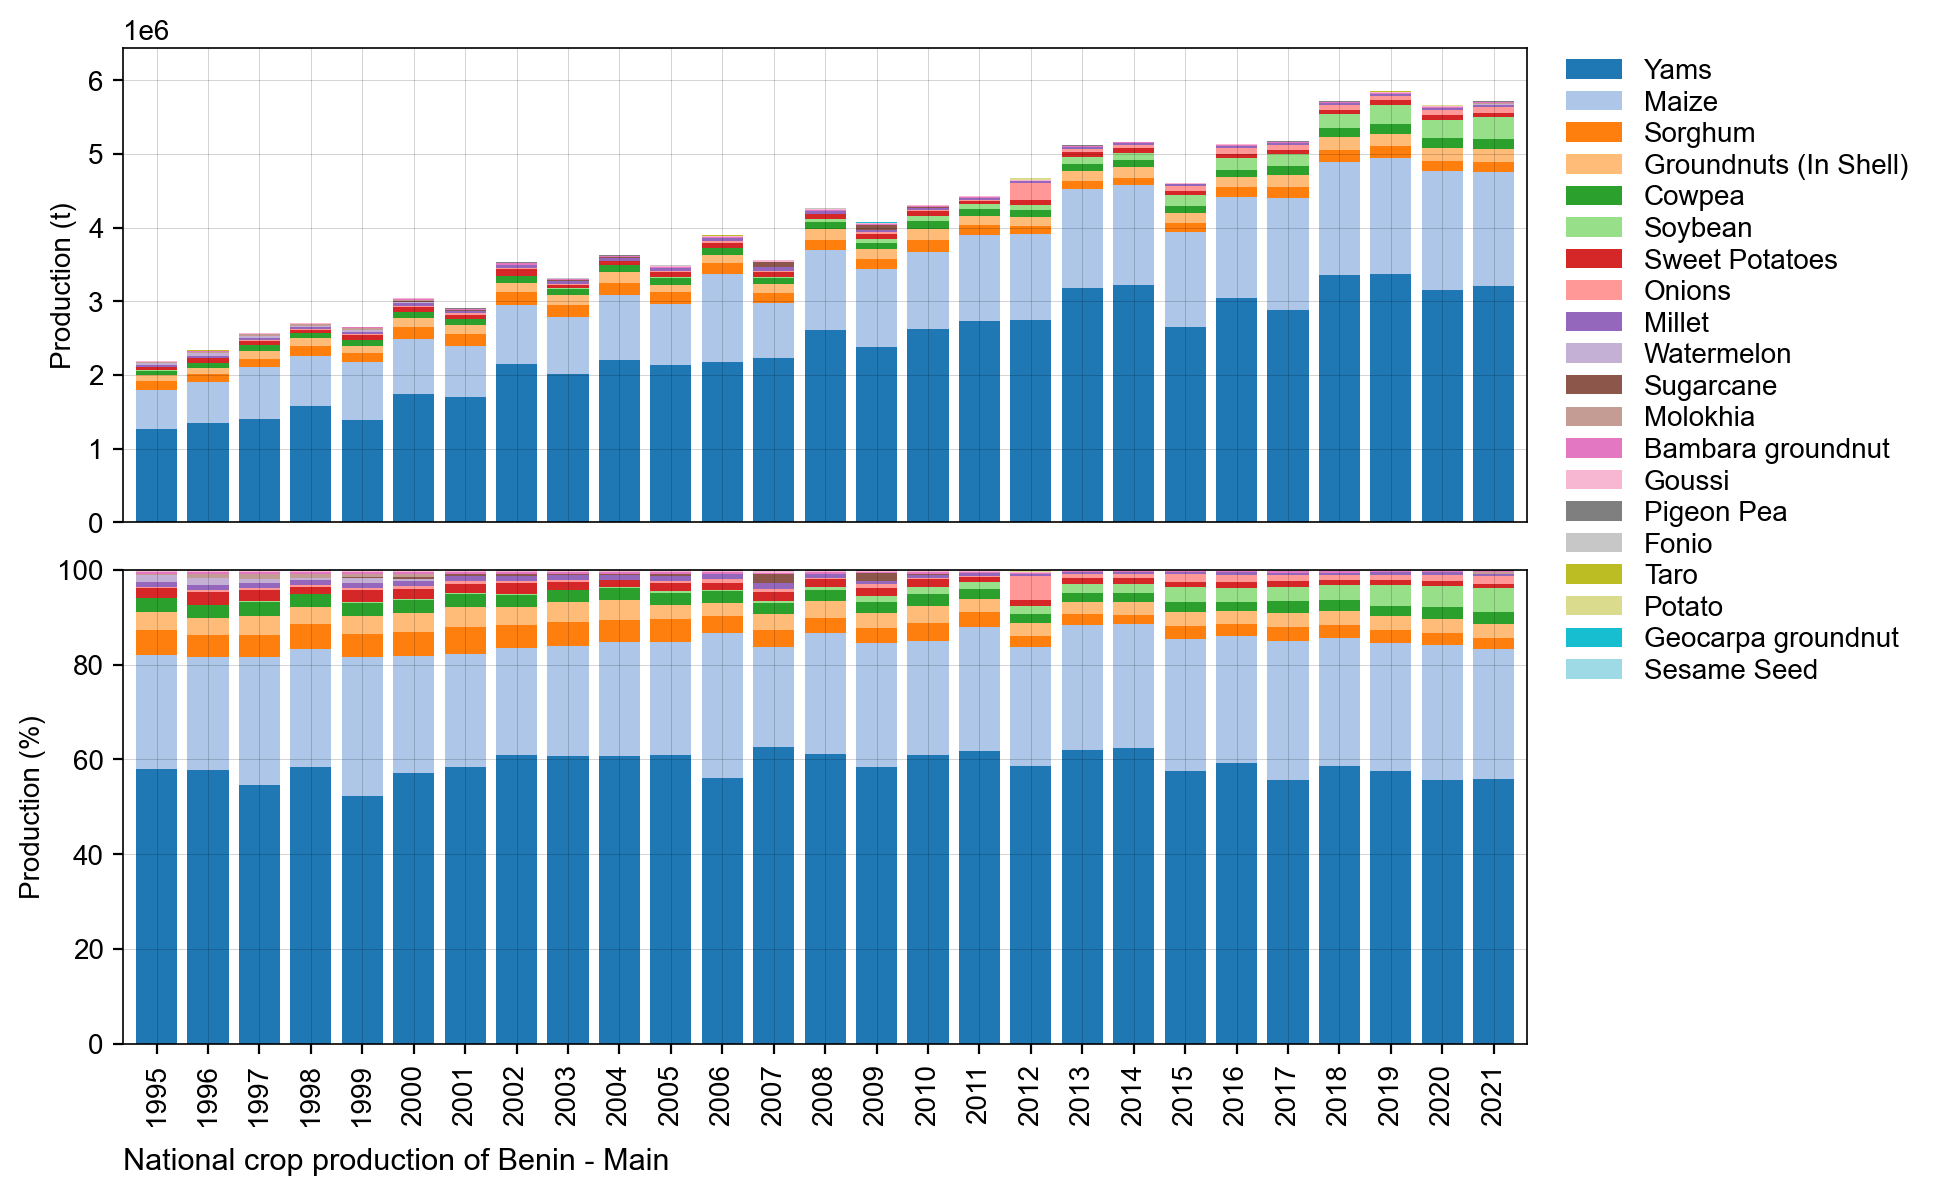

../figures/BJ_bar_natgrainprod_Main.png is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


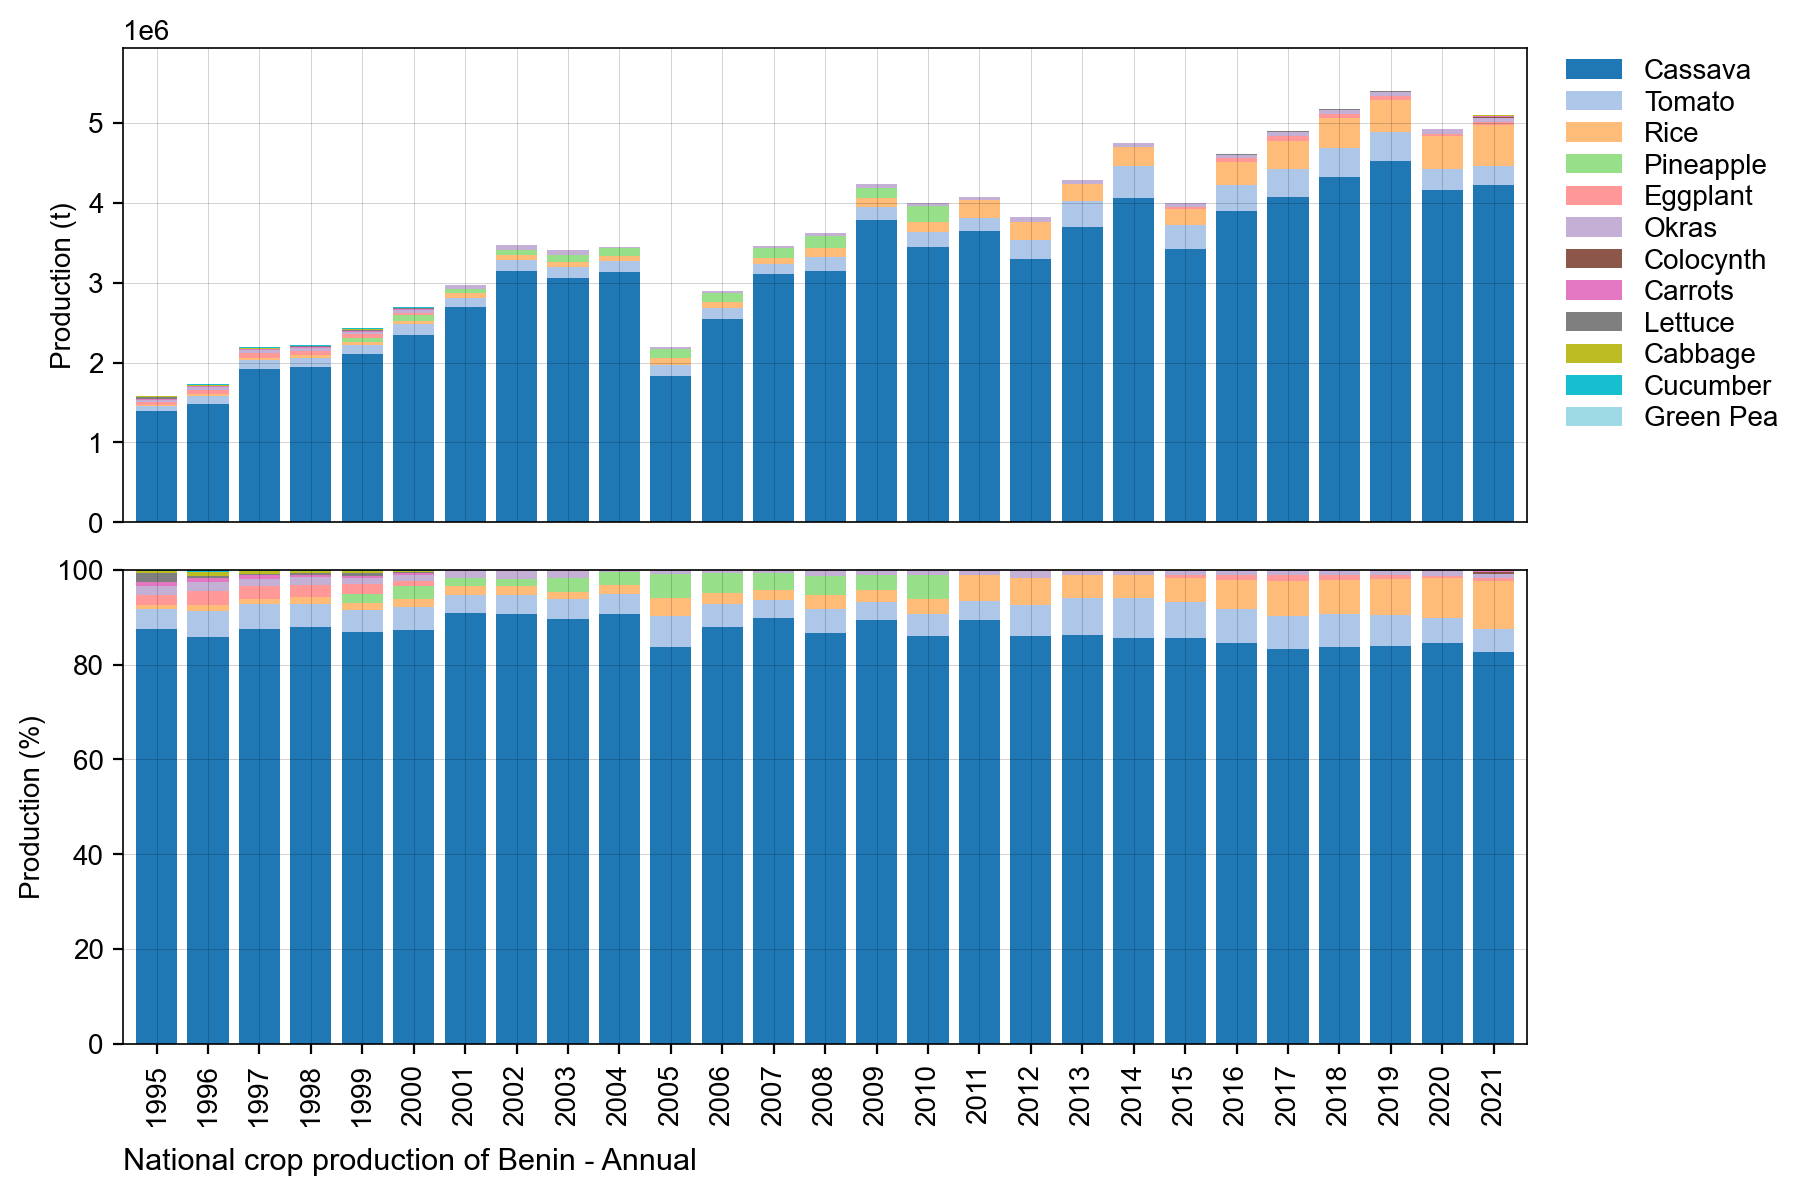

../figures/BJ_bar_natgrainprod_Annual.png is saved.


In [10]:
# Bar chart of national crop production
country_iso, country_name = 'BJ', 'Benin'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main', 'Annual']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

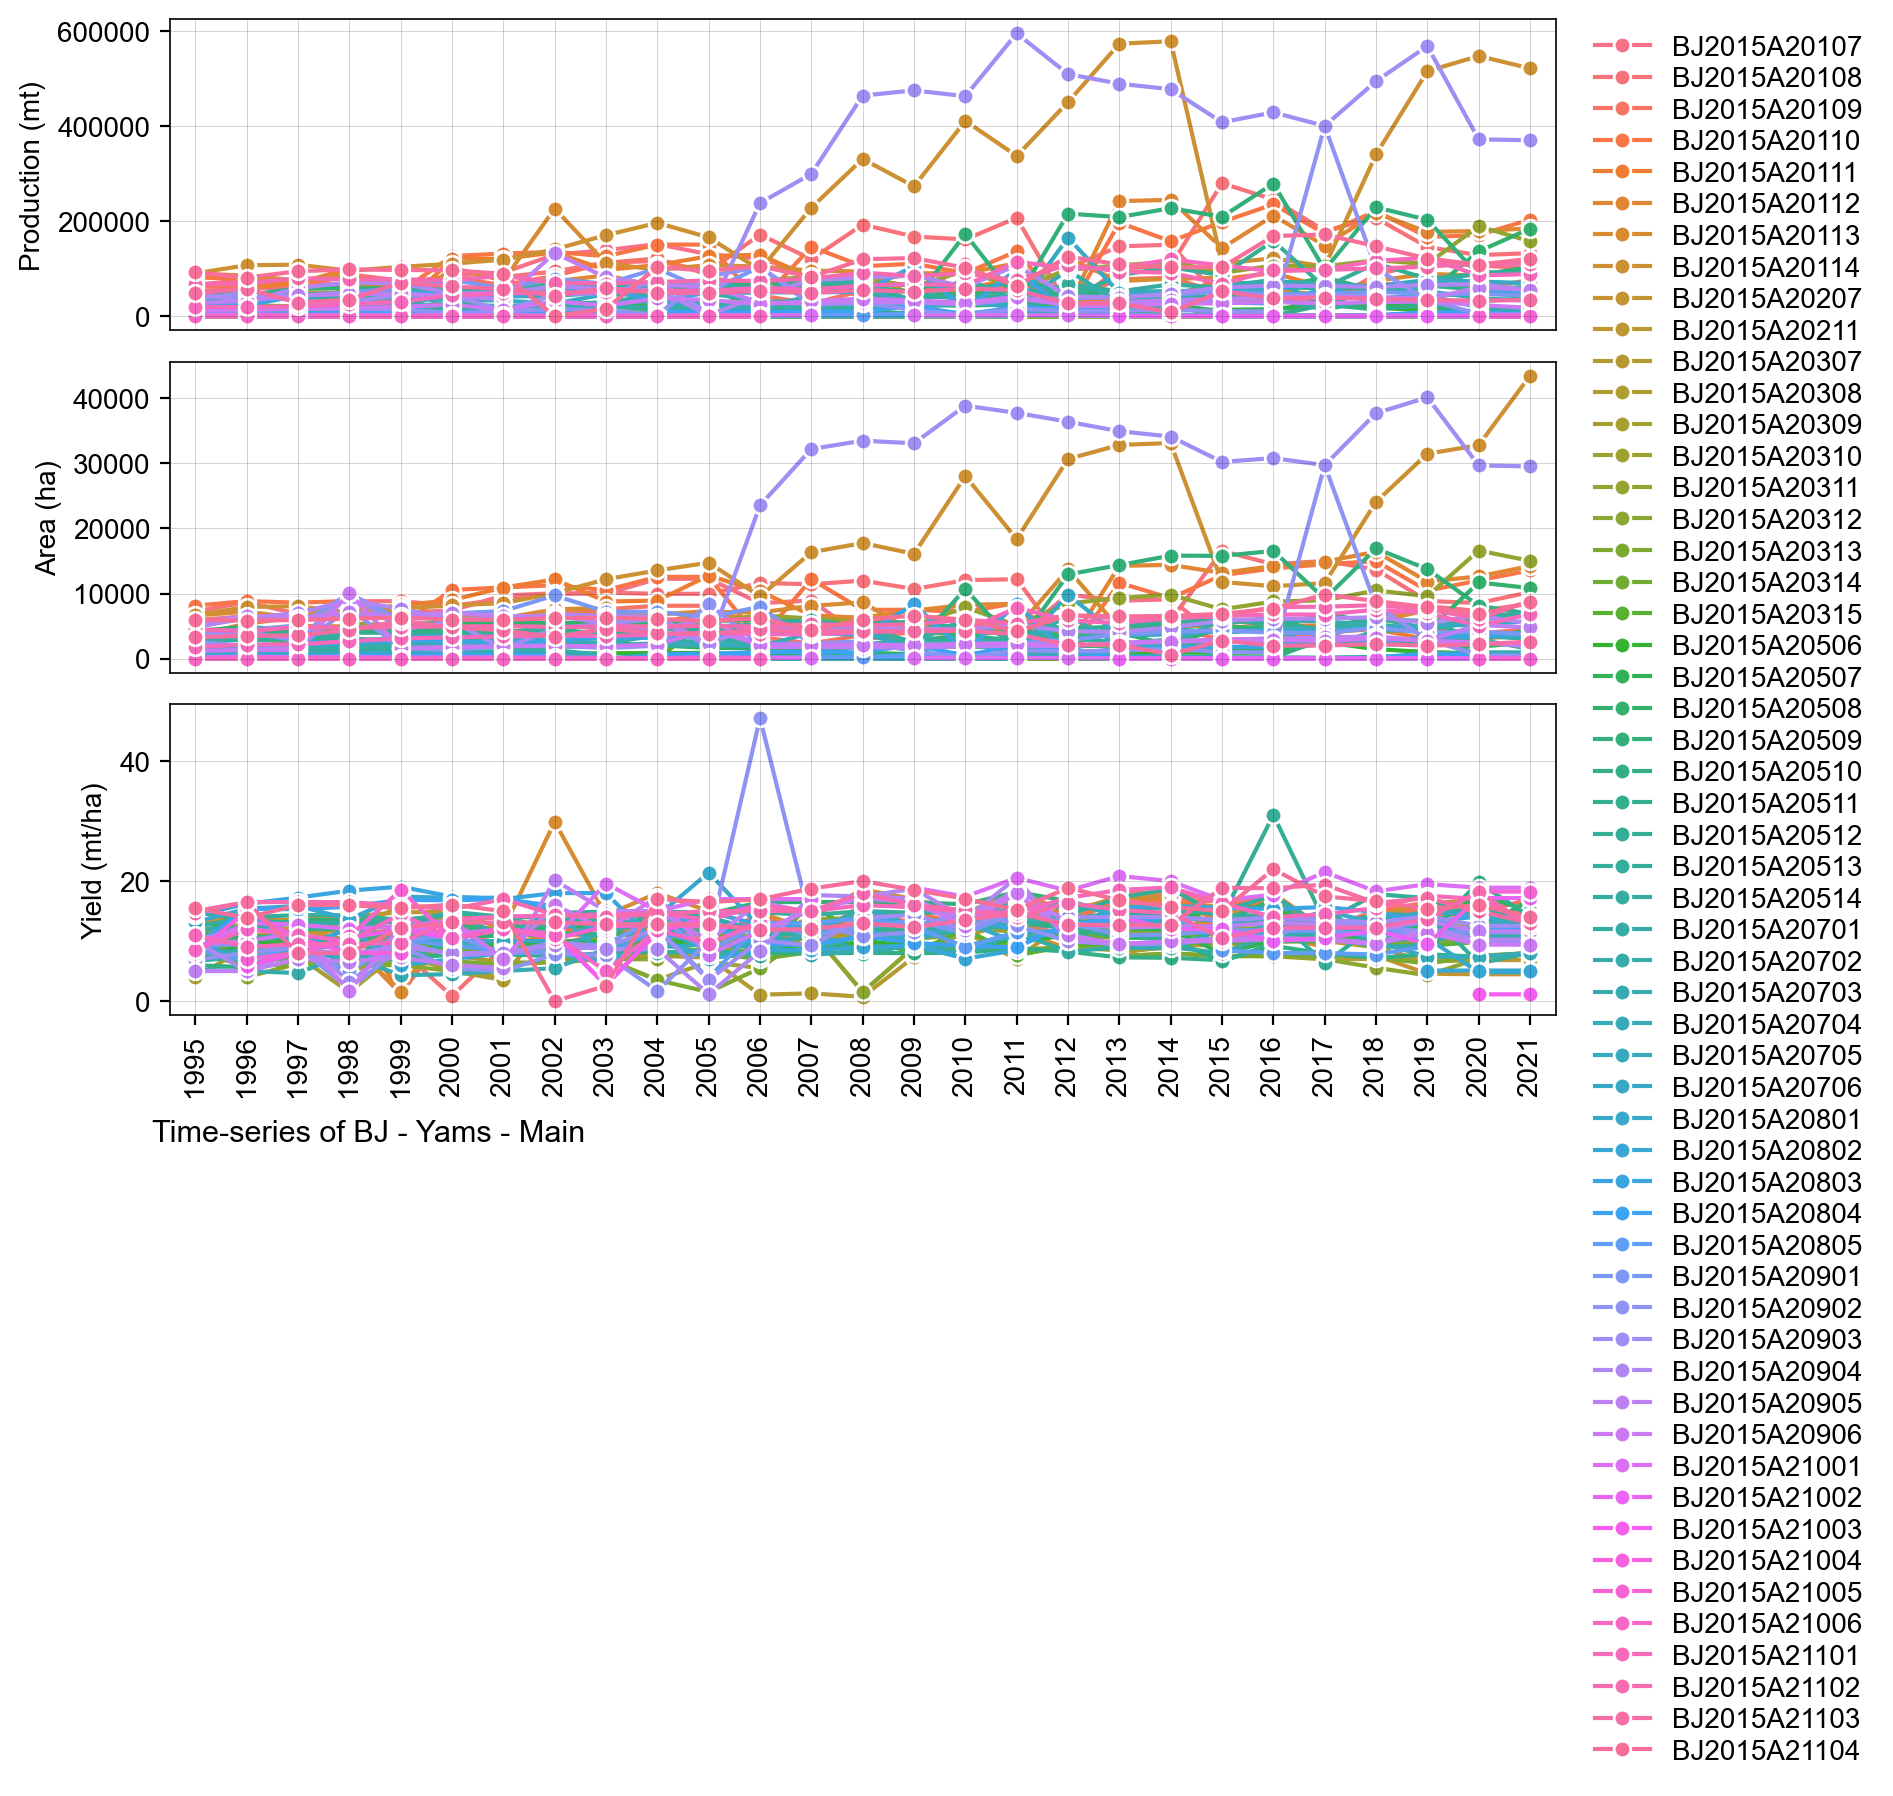

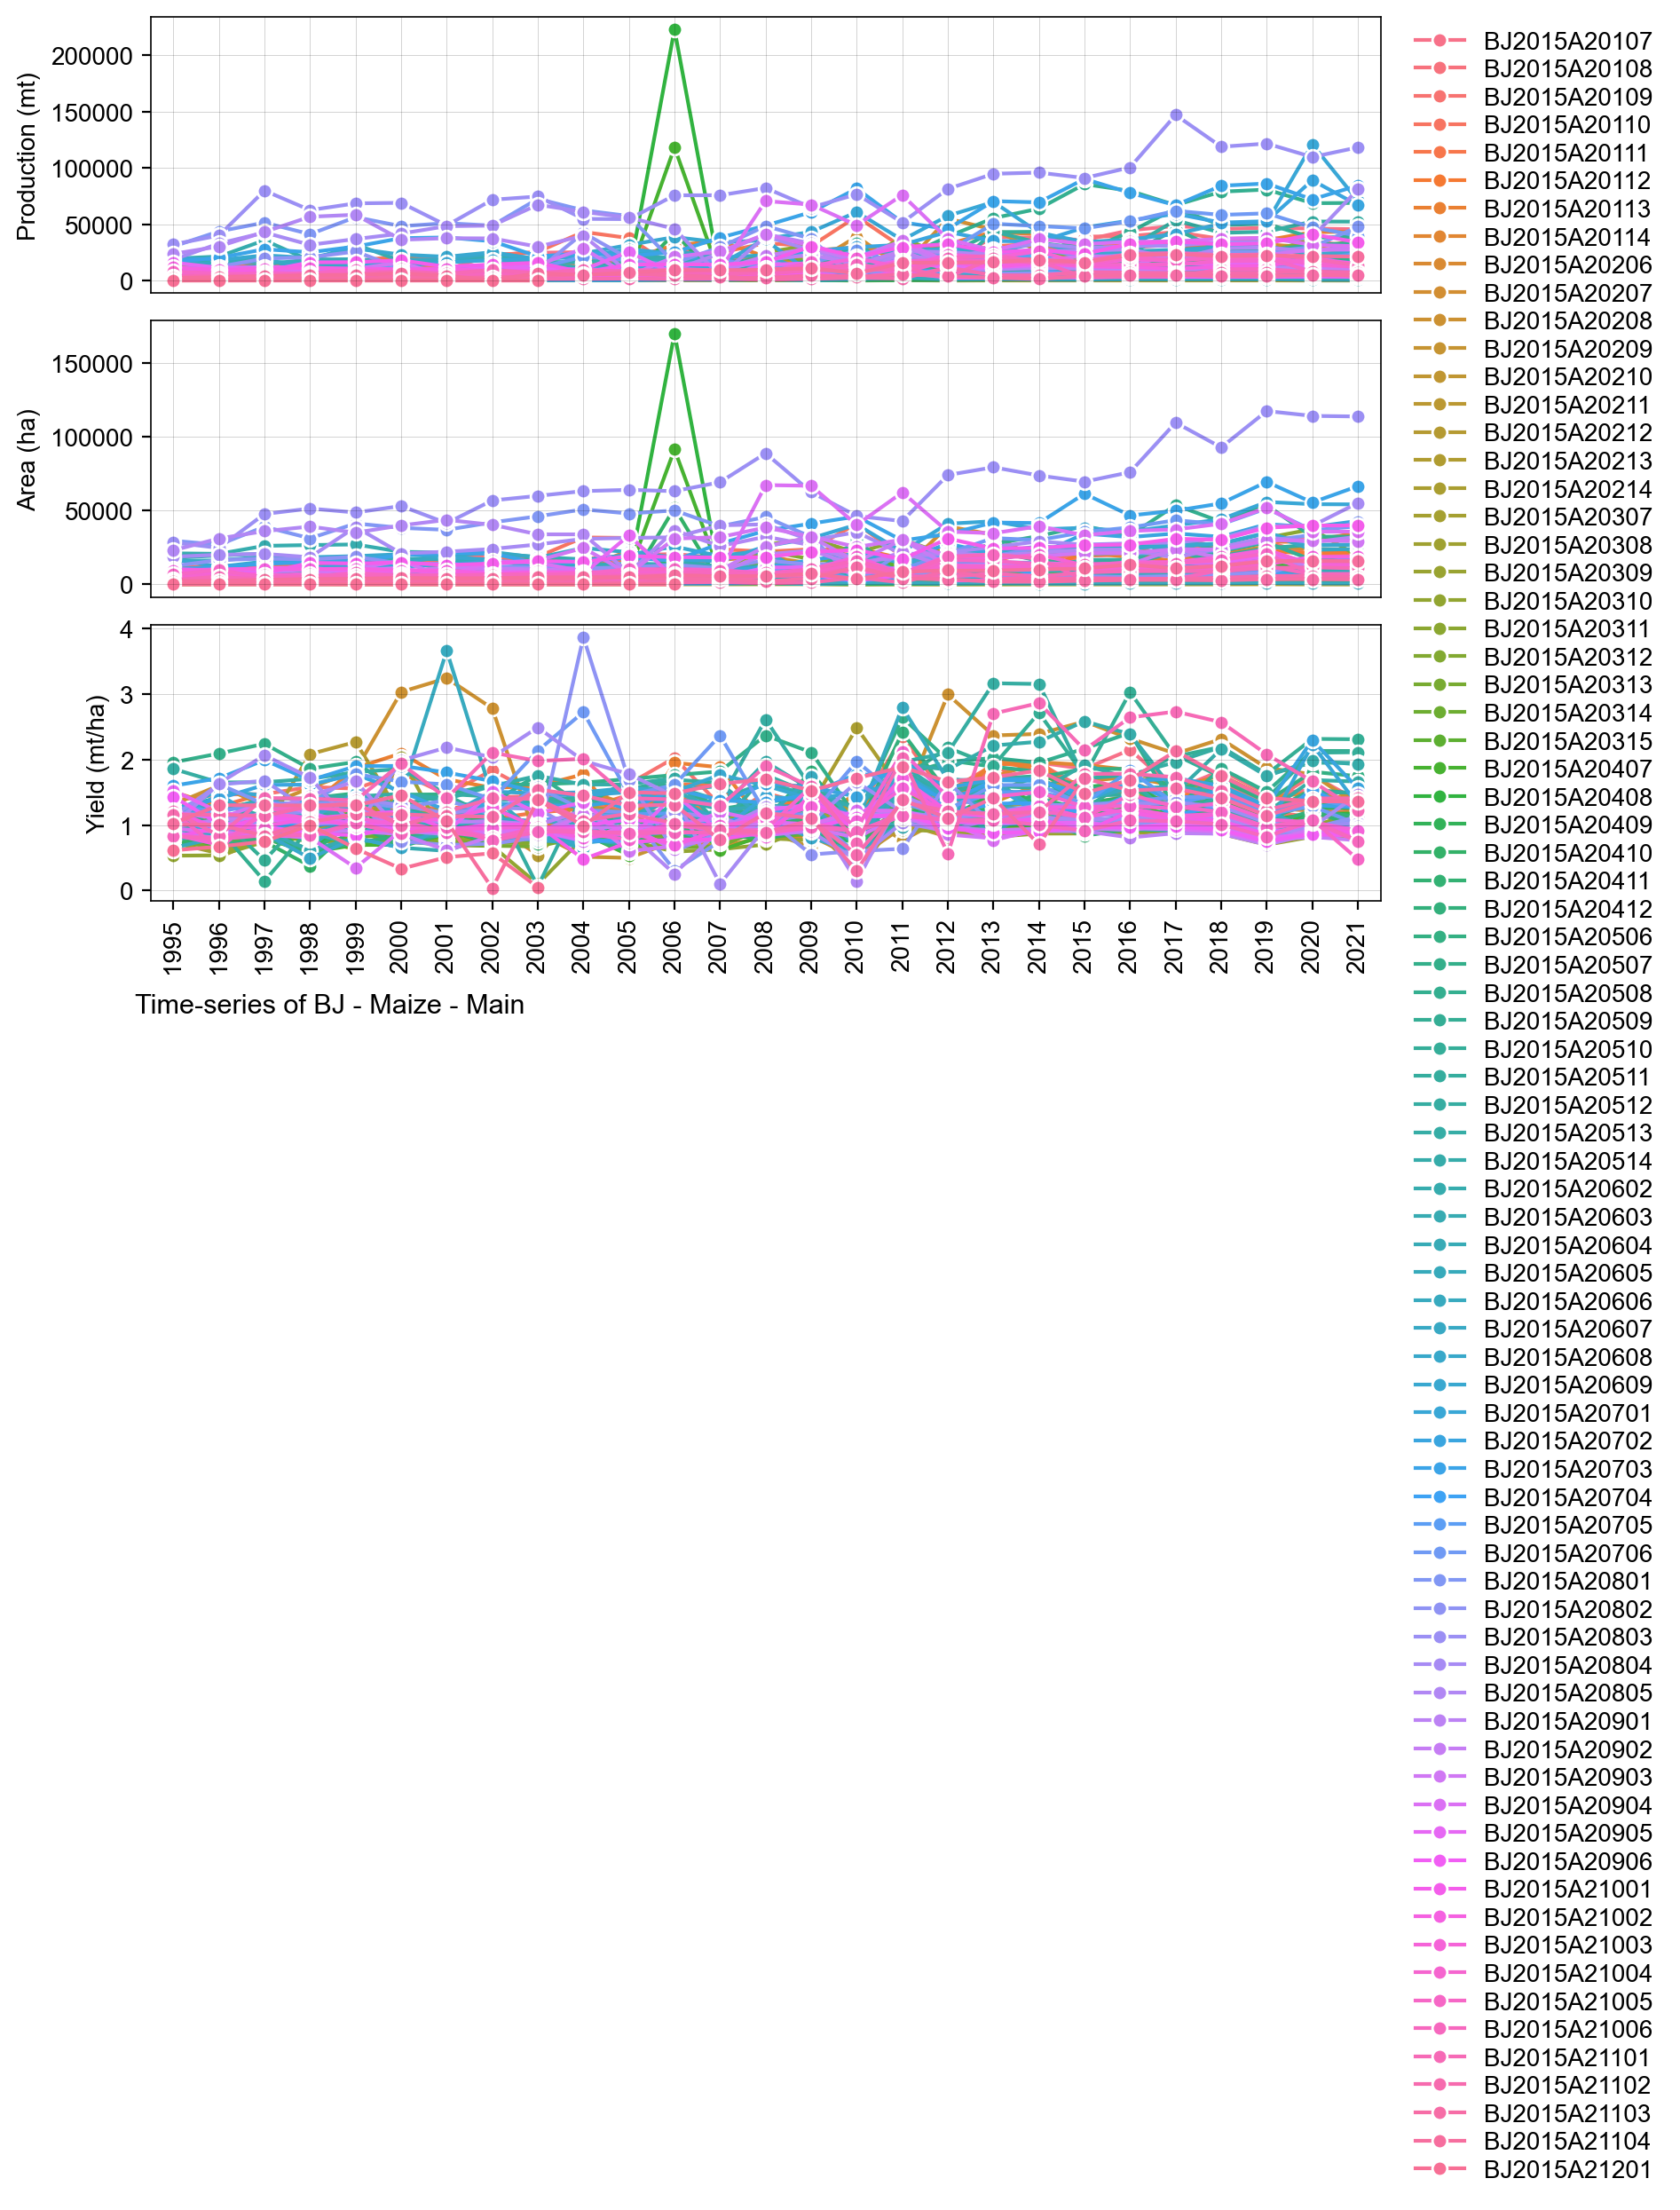

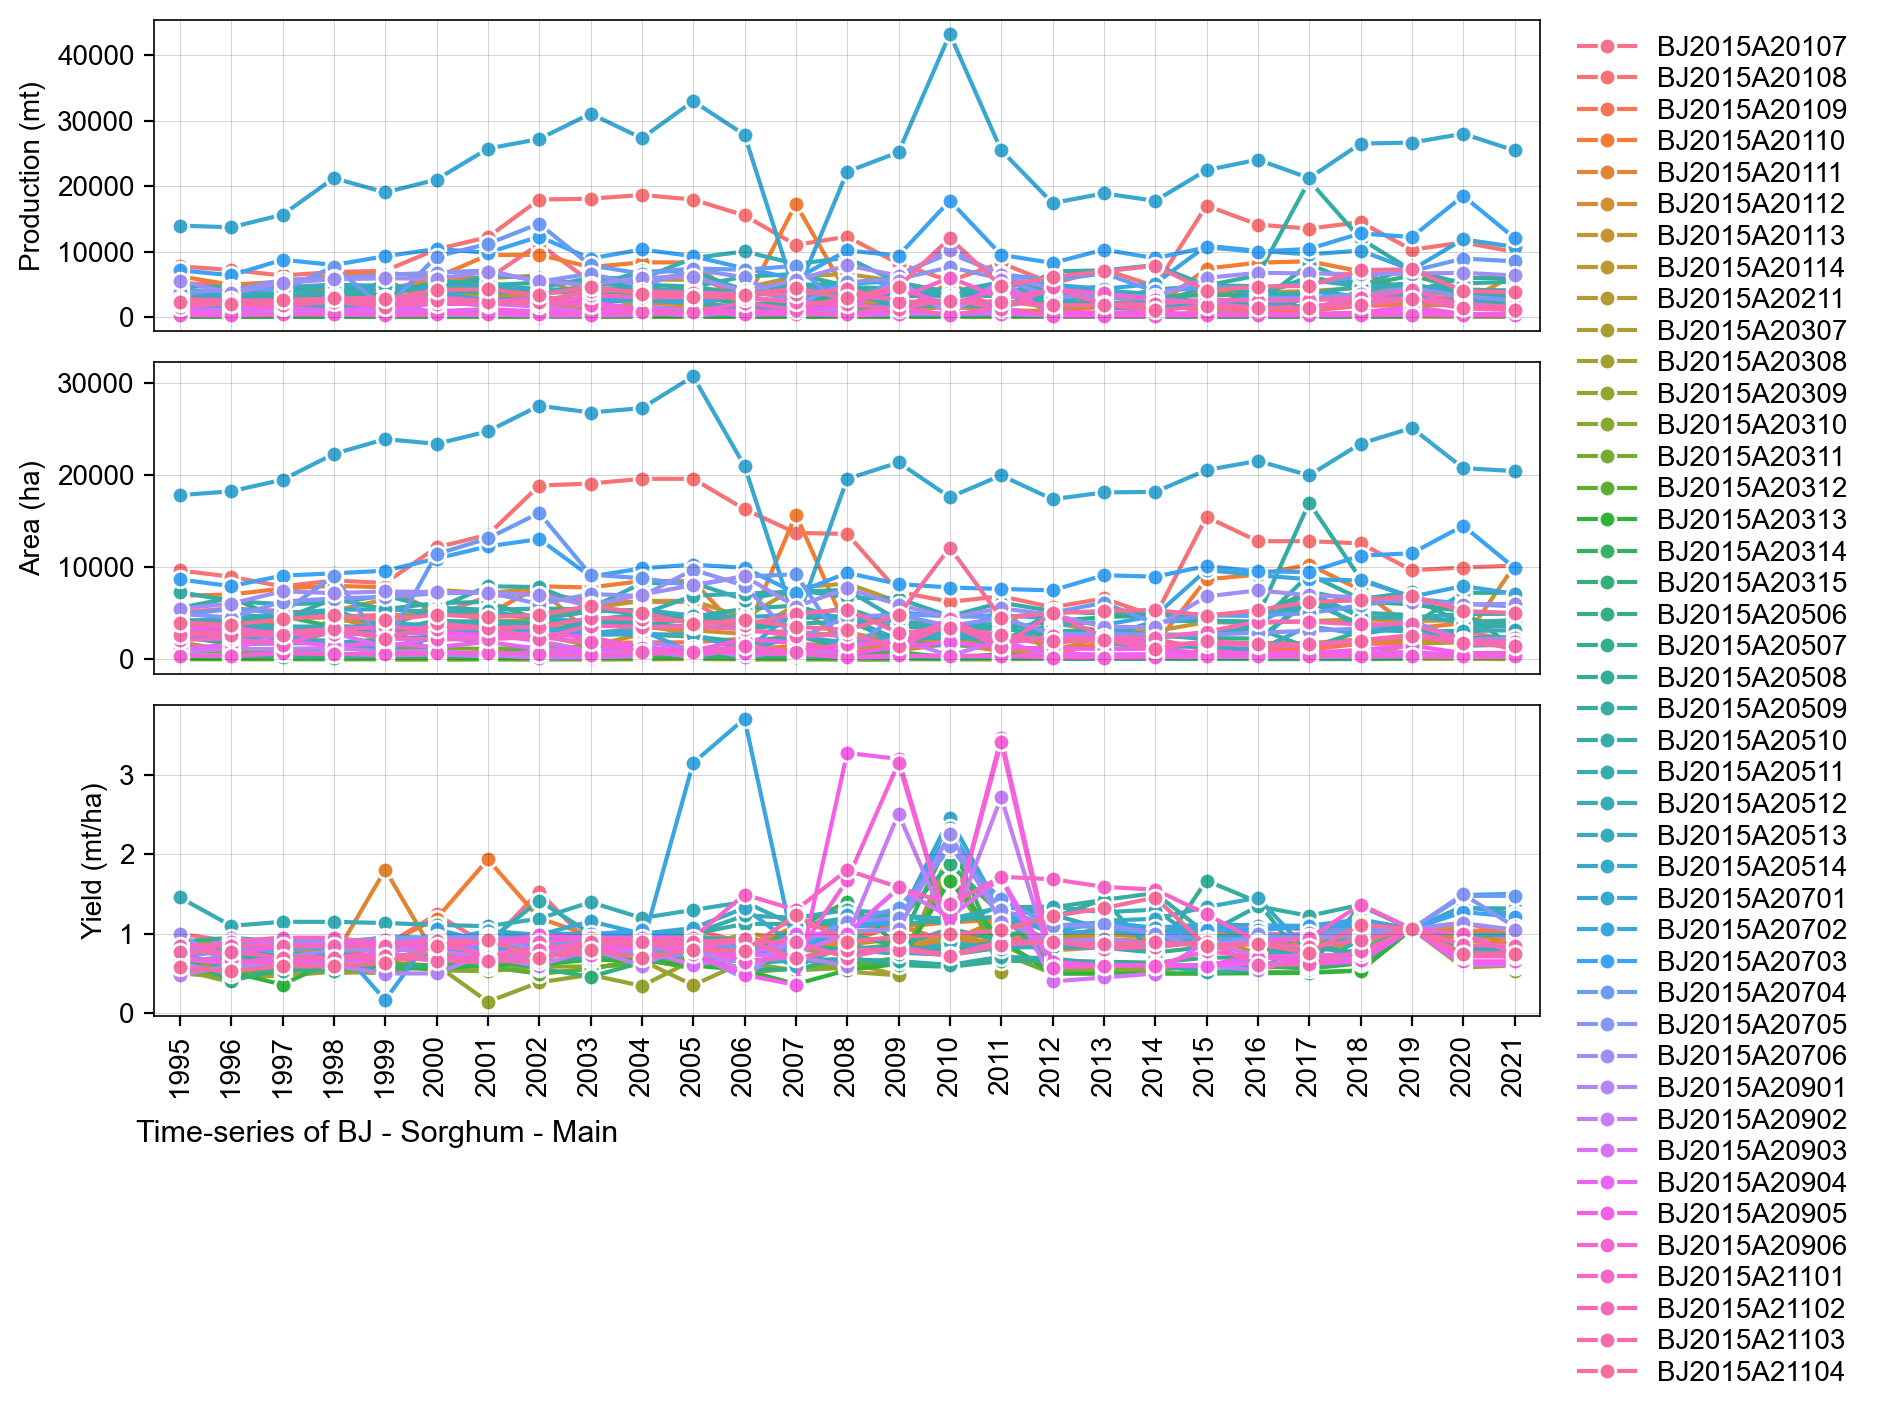

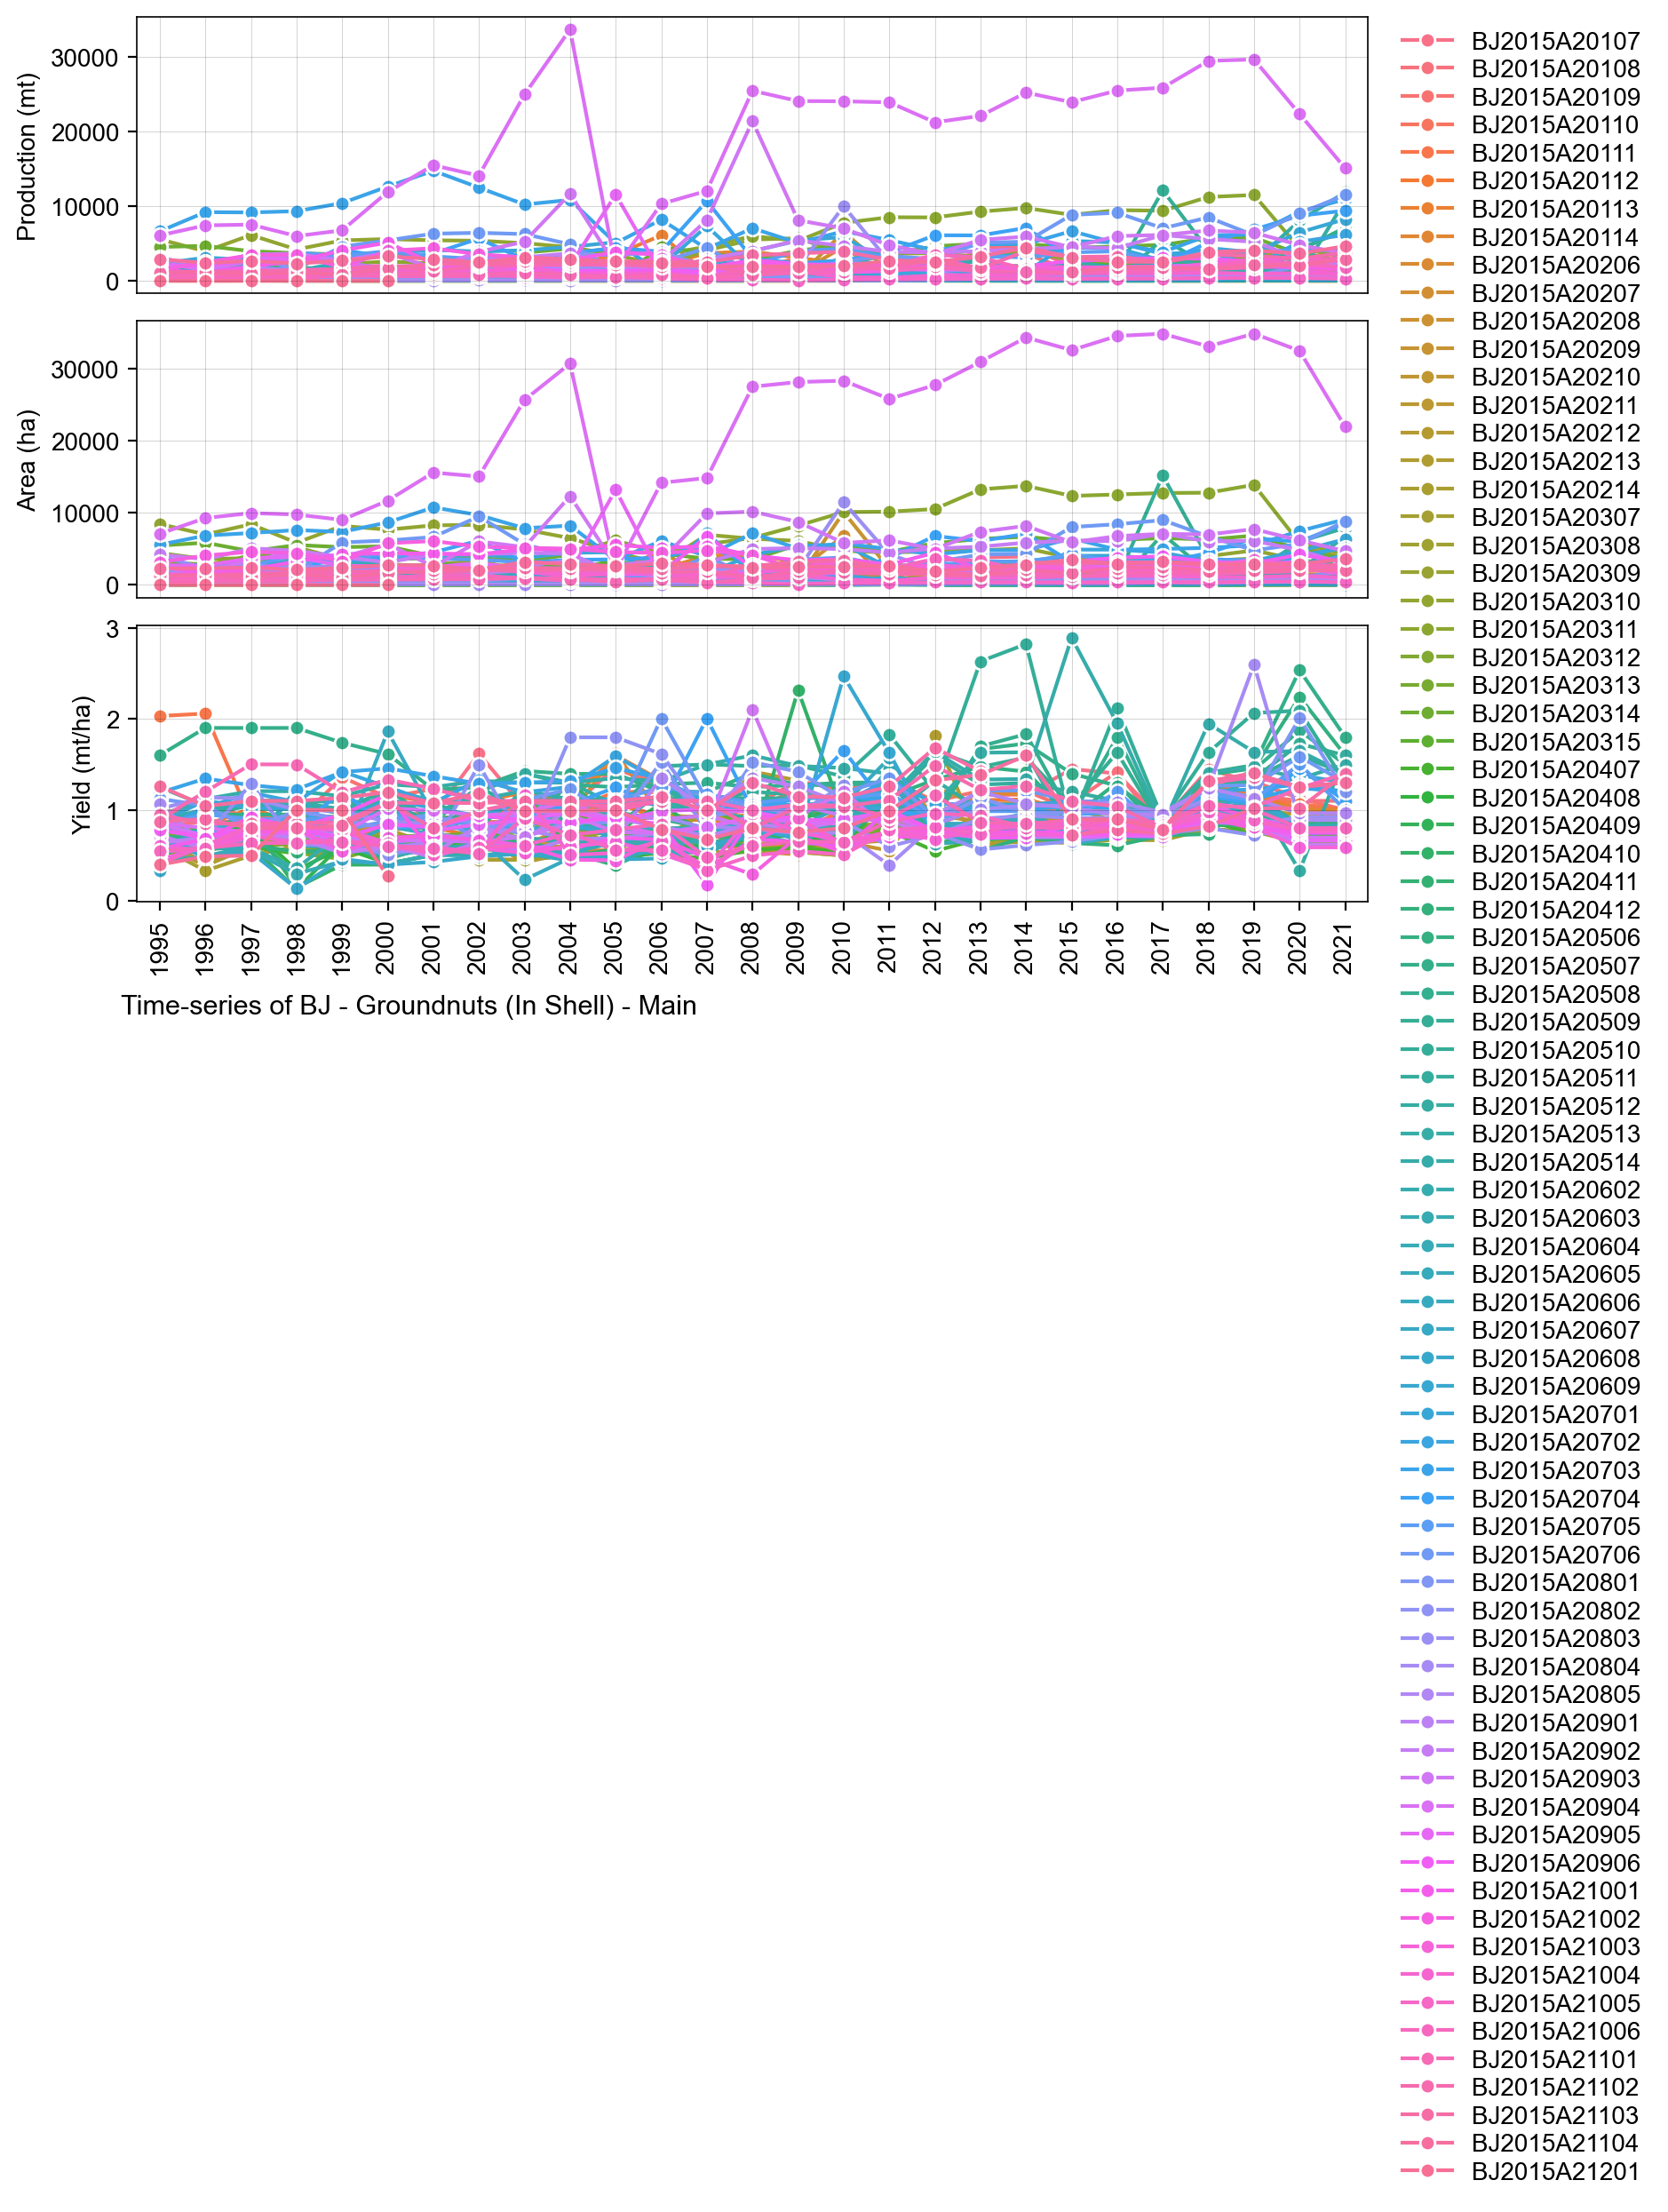

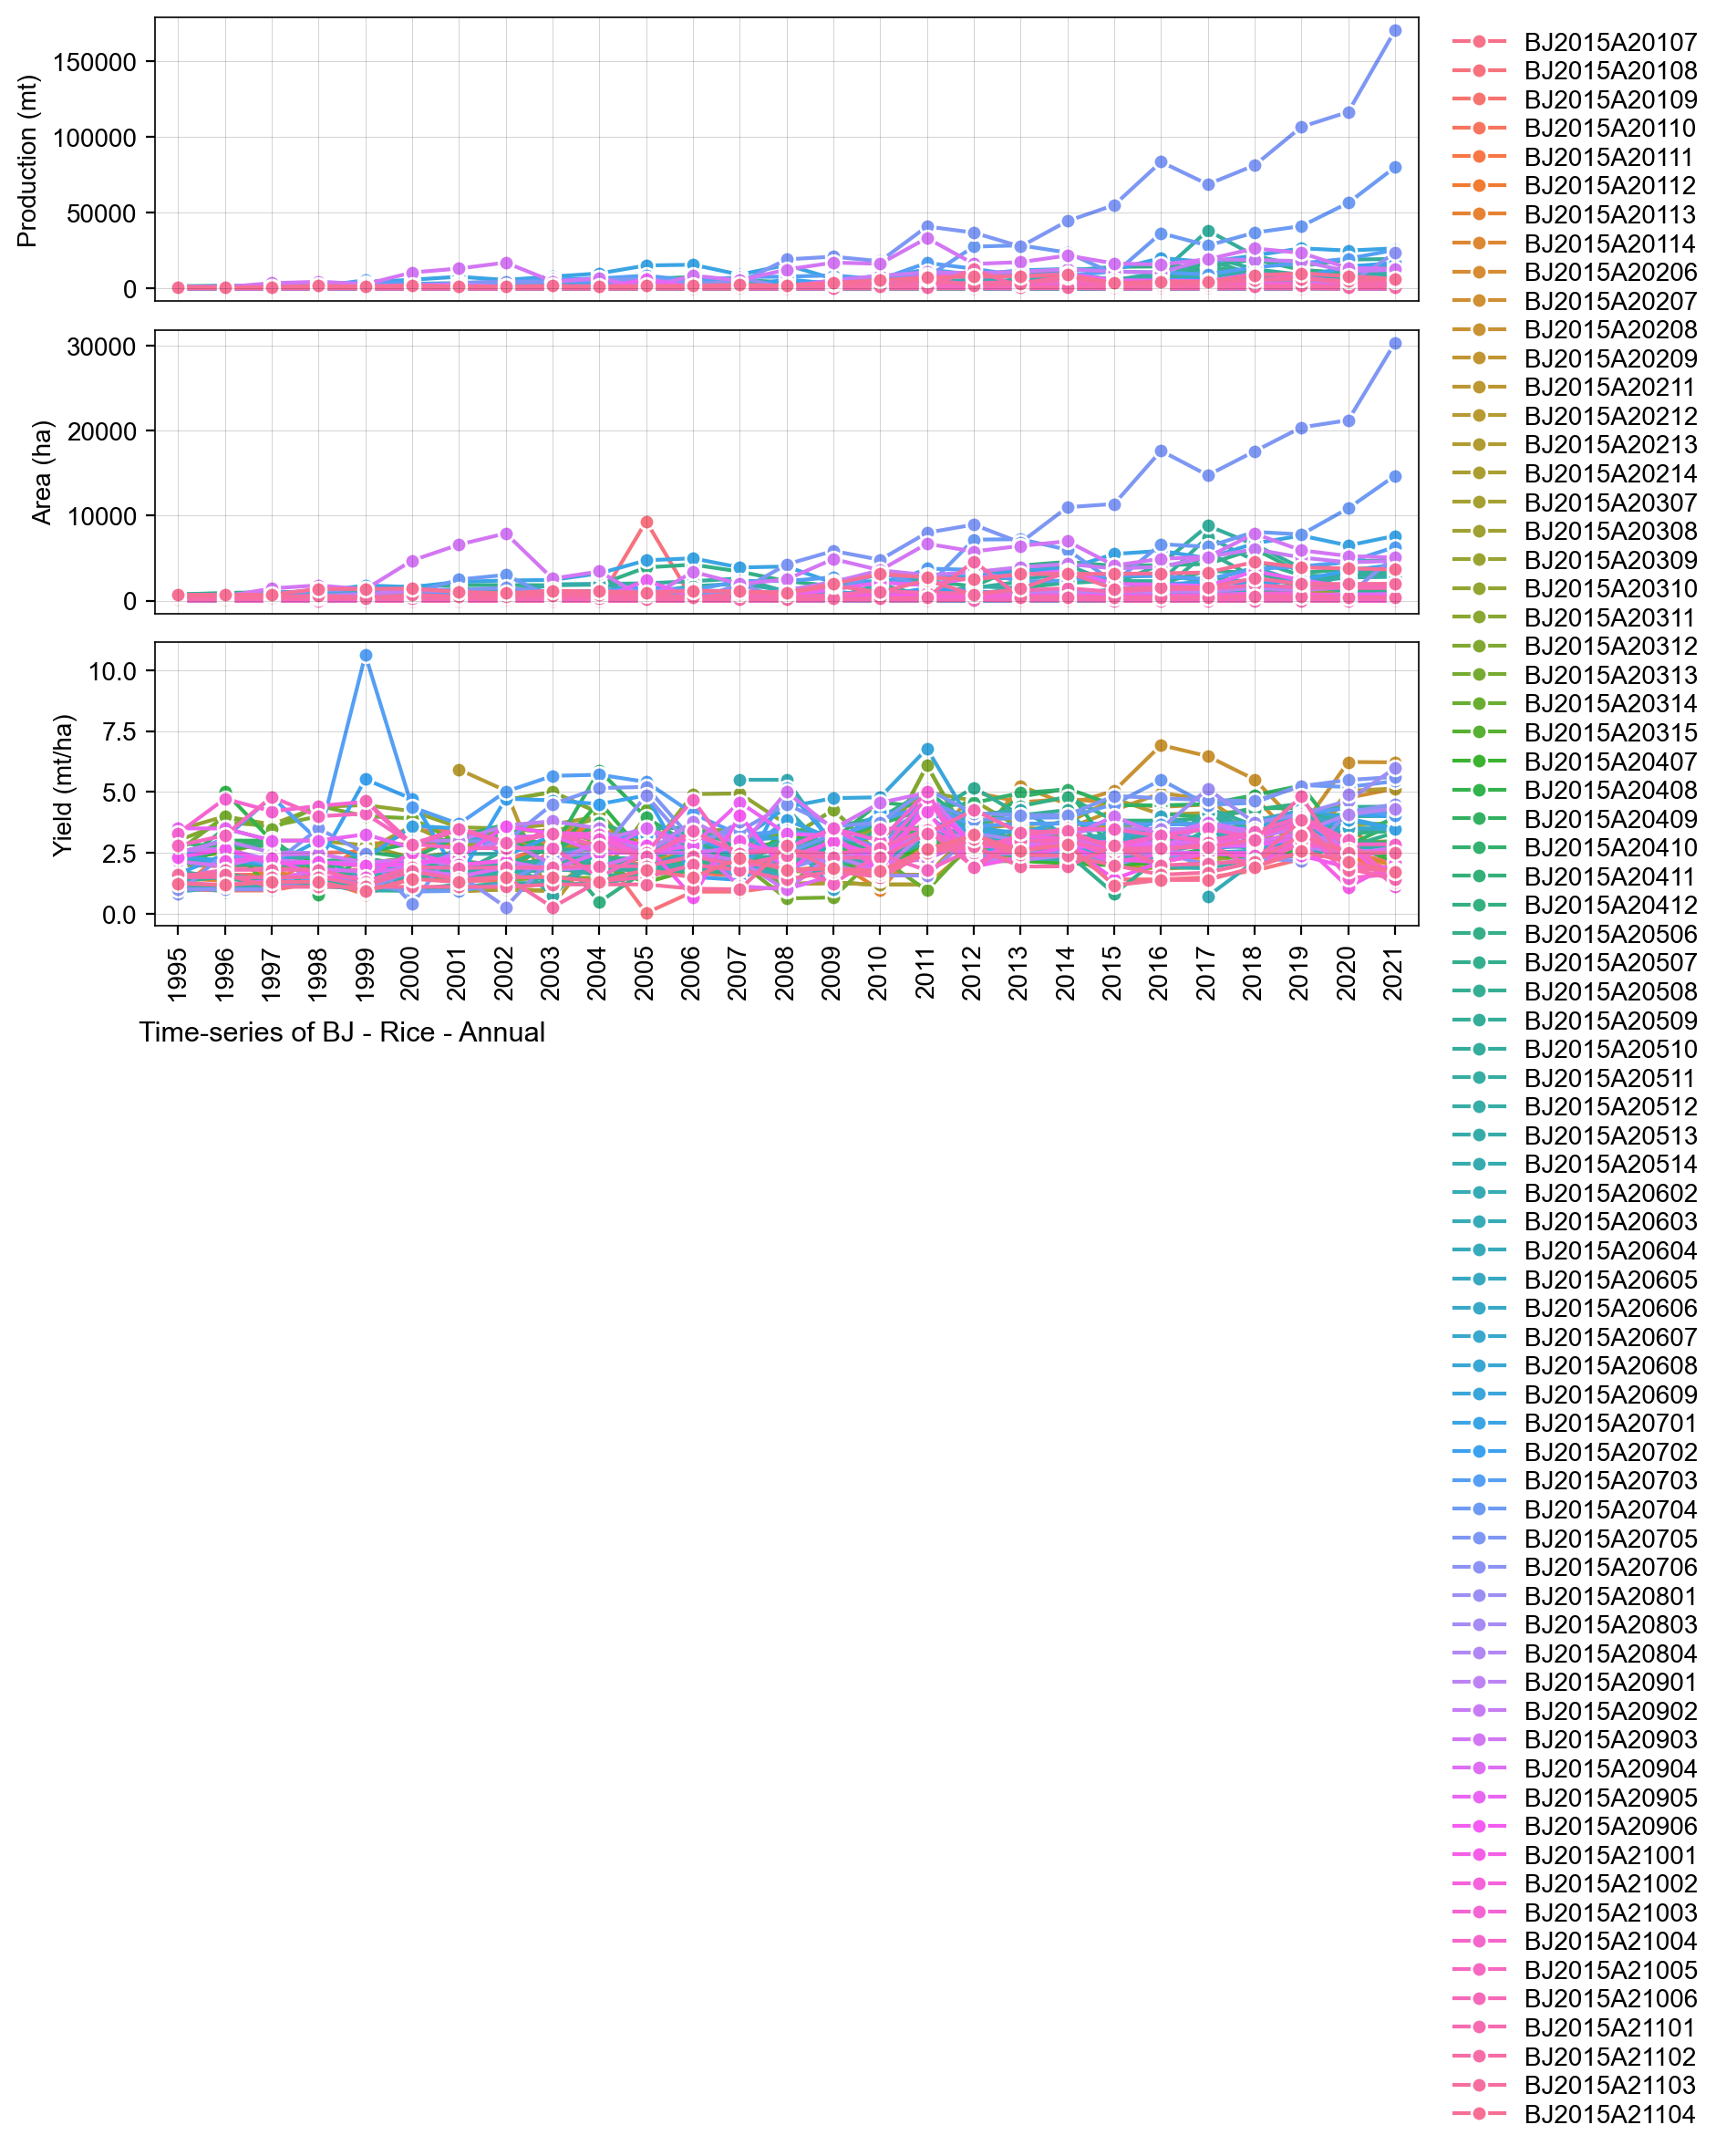

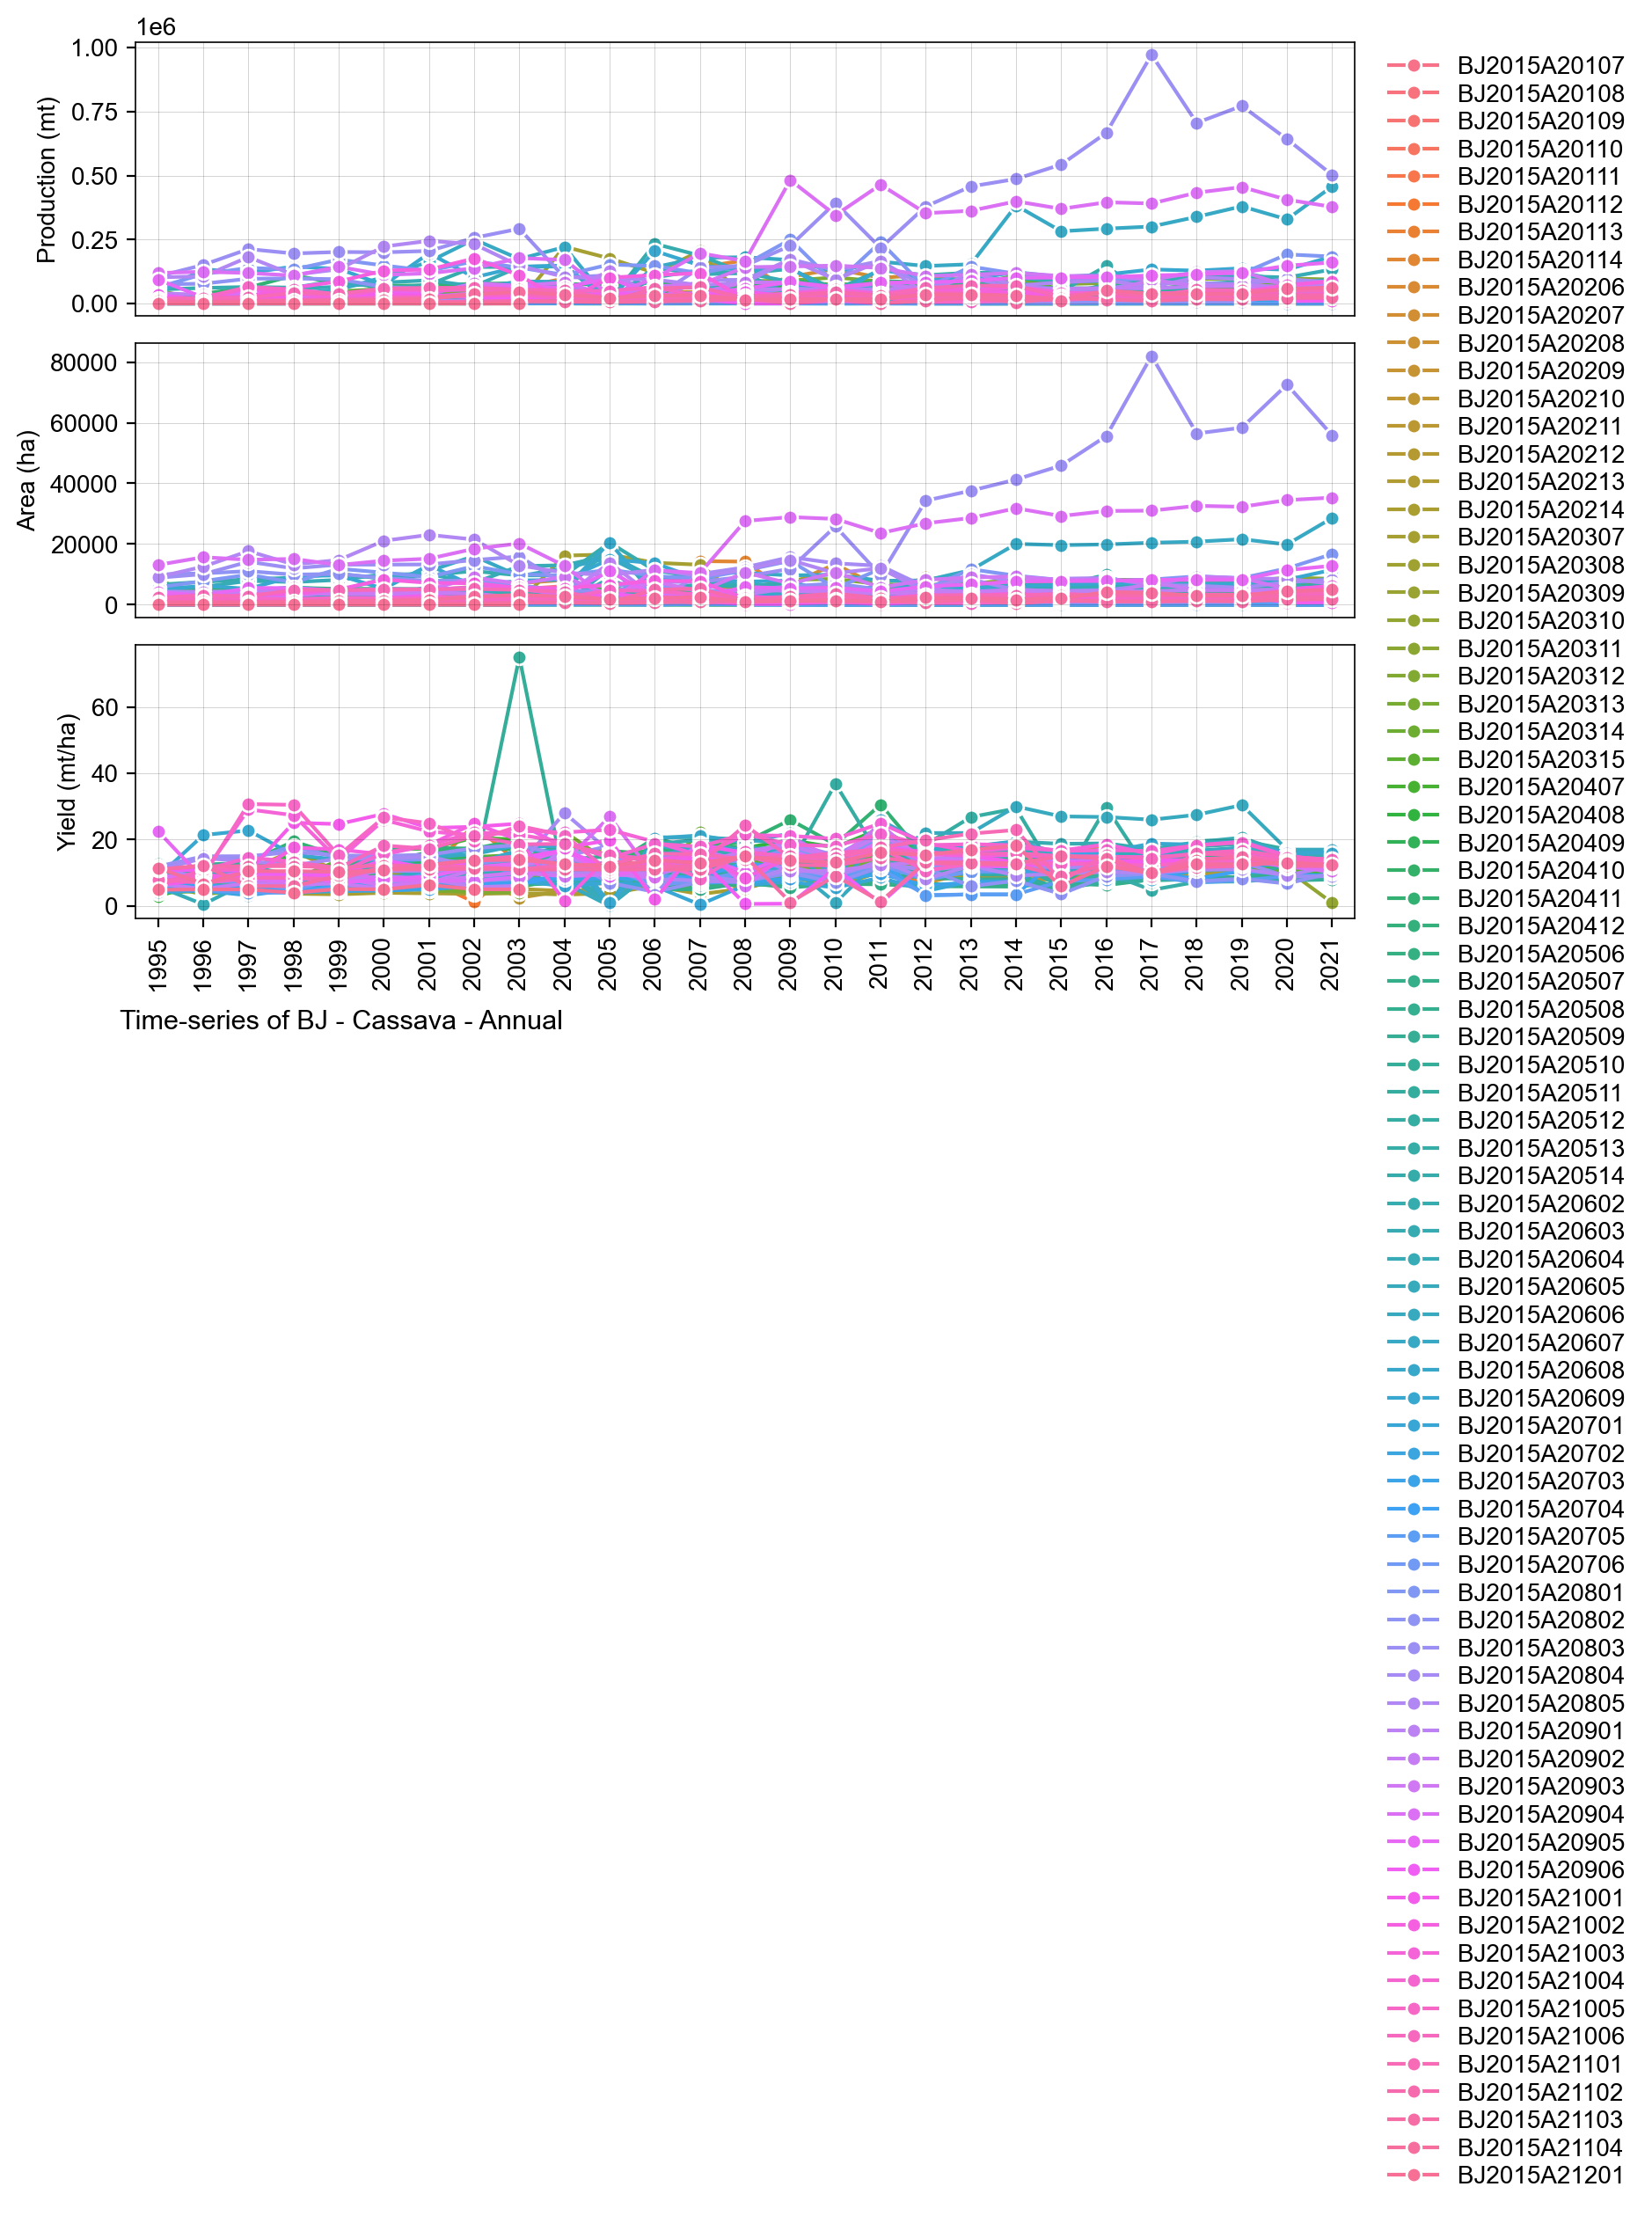

In [11]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'BJ', 'Benin'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Yams','Main'],
    ['Maize','Main'],
    ['Sorghum','Main'],
    ['Groundnuts (In Shell)','Main'],  
    ['Rice','Annual'],
    ['Cassava','Annual'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)